In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-bore/Data_withbore.csv
/kaggle/input/data-bore-n/Data_withbore.csv


In [59]:
df = pd.read_csv('/kaggle/input/data-bore/Data_withbore.csv')
df['Working _fine'] = df['Working _fine'].apply(lambda x: 1 if x == 'Y' else 0) 
cols = ['Notches' , 'Notch Angle degree']
df[cols] = df[cols].bfill()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df = df.sample(frac = 1.0 , random_state = 42)
df = df.reset_index(drop = True)
df_temp = df.copy()
X = df_temp.drop('Bush OD' , axis = 1)
y = df_temp.pop('Bush OD')
not_null_ind = []
null_ind = []
for i,ele in enumerate(y):
    if pd.isna(ele) == False:
        not_null_ind.append(i)
    else:
        null_ind.append(i)
X_temp = X.iloc[not_null_ind]
y_temp = y.iloc[not_null_ind]

X_temp1 = X.iloc[null_ind]


In [3]:
X_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 81
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tons                70 non-null     float64
 1   Bush Length         70 non-null     float64
 2   WP                  70 non-null     int64  
 3   Bore                70 non-null     int64  
 4   Rod                 70 non-null     int64  
 5   Stroke              70 non-null     float64
 6   Type                70 non-null     int64  
 7   Clearance           70 non-null     float64
 8   Notches             70 non-null     float64
 9   Notch Angle degree  70 non-null     float64
 10  Notch length(mm)    70 non-null     float64
 11  Working _fine       70 non-null     int64  
dtypes: float64(7), int64(5)
memory usage: 7.1 KB


See if you can find the original bush OD's to make this model more robust

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Arrays to store the performance metrics
mse_scores = []
r2_scores = []
# y_copy = df['Bush OD']
# null_ind = list(y_copy[~(y_copy >= 0)].index)
# df_copy = df.copy()

# cols_to_drop = ['WP']

all_predictions = []
# Loop over random states from 0 to 42
for i in range(27):
#     print(i)
    # Split the data with the current random state
    X_train, X_test, y_train, y_test = train_test_split(X_temp[0:46], y_temp[0:46], test_size=0.2, random_state=i)
#     print(X_train.info())
    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Create and train the regressor
    regressor = DecisionTreeRegressor(random_state=4)
    regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = regressor.predict(X_test)
    y_temp1 = regressor.predict(X_temp1)
    all_predictions.append(y_temp1)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the scores
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the mean and standard deviation of the performance metrics
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
all_predictions = np.array(all_predictions)

# Calculate the mean prediction for each point
y_pred_final = np.mean(all_predictions, axis=0)


# Print or return the mean predictions
print("Predictions for new points:", y_pred_final)

print(f"Mean MSE: {mean_mse:.2f} ± {std_mse:.2f}")
print(f"Mean R^2: {mean_r2:.2f} ± {std_r2:.2f}")




Predictions for new points: [56.96896296 56.97814815 57.00222222 56.95177778 64.71462963 65.45259259
 56.99814815 56.97814815 56.95177778 63.80407407 64.52944444 56.99703704
 64.97185185]
Mean MSE: 22.14 ± 31.97
Mean R^2: 0.85 ± 0.18


In [5]:
df.loc[null_ind , 'Bush OD'] = y_pred_final
# df = df_temp.copy()
df_temp = df.copy()
X = df_temp.drop('Working _fine' , axis = 1)
y = df_temp.pop('Working _fine')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tons                83 non-null     float64
 1   Bush Length         83 non-null     float64
 2   WP                  83 non-null     int64  
 3   Bore                83 non-null     int64  
 4   Rod                 83 non-null     int64  
 5   Stroke              83 non-null     float64
 6   Type                83 non-null     int64  
 7   Bush OD             83 non-null     float64
 8   Clearance           83 non-null     float64
 9   Notches             83 non-null     float64
 10  Notch Angle degree  83 non-null     float64
 11  Notch length(mm)    83 non-null     float64
 12  Working _fine       83 non-null     int64  
dtypes: float64(8), int64(5)
memory usage: 8.6 KB


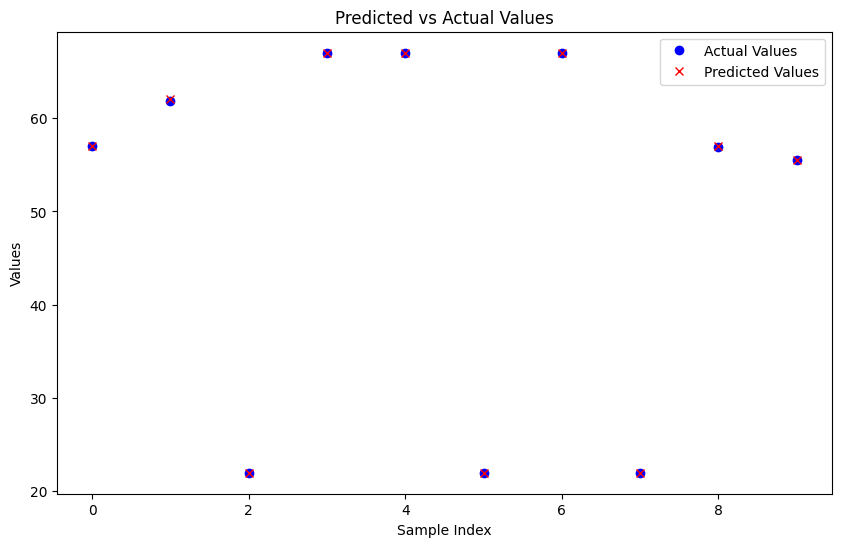

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, 'o', color='blue', label='Actual Values')
plt.plot(y_pred, 'x', color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

In [35]:
X

,Tons,Bush Length,WP,Bore,Rod,Stroke,Type,Bush OD,Clearance,Notches,Notch Angle degree,Notch length(mm)
0,5.50,44.50,240,90,60,700.50,1,55.56,-0.07,3.00,1.02,35.70
1,4.80,35.00,240,80,50,698.50,1,56.94,0.11,3.00,1.20,26.00
2,5.50,44.50,240,90,60,700.50,1,65.47,0.11,3.00,1.20,35.50
3,5.50,44.50,240,90,60,700.50,1,55.54,-0.11,3.00,0.98,35.70
4,5.50,39.00,240,90,60,700.50,1,66.97,0.08,2.00,0.05,33.00
...,...,...,...,...,...,...,...,...,...,...,...,...
78,5.50,39.00,240,90,60,700.50,1,66.97,0.08,3.00,1.20,30.00
79,4.80,35.00,240,80,50,698.50,1,57.00,0.09,2.00,1.20,26.00
80,2.60,27.00,270,75,45,497.00,0,22.00,0.25,4.00,1.50,24.00
81,5.50,39.00,240,90,60,700.50,1,66.94,0.11,3.00,1.20,30.00


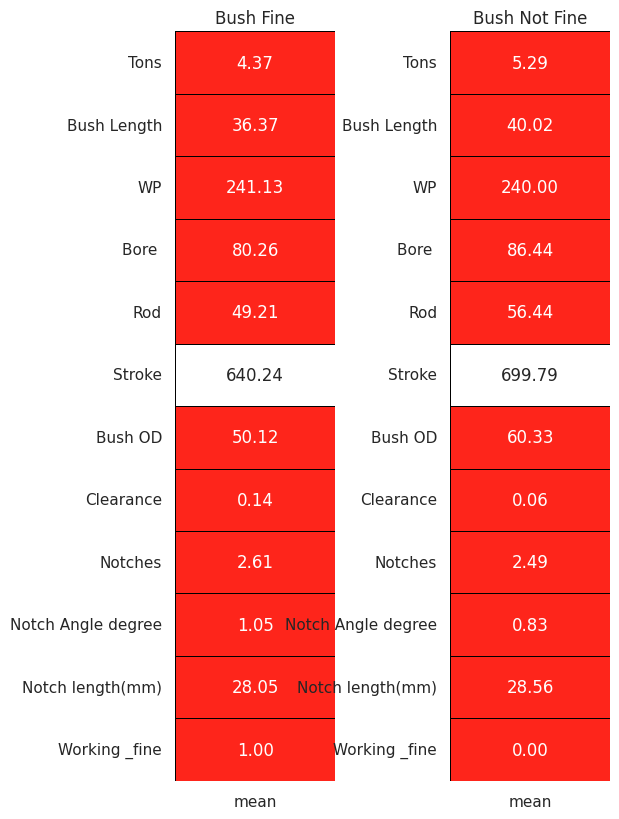

In [516]:
yes = df[df['Working _fine'] == 1].drop('Type' , axis = 1).describe().T
no = df[df['Working _fine'] == 0].drop('Type', axis = 1).describe().T

colors = ['#FE251B','#FFFFFF']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,7),)
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Bush Fine');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Bush Not Fine');

fig.tight_layout(pad = -3)

In [347]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Rod Type Notches Working _fine
Numerical Features : Tons Bush Length WP Bore  Stroke Bush OD Clearance Notch Angle degree Notch length(mm)


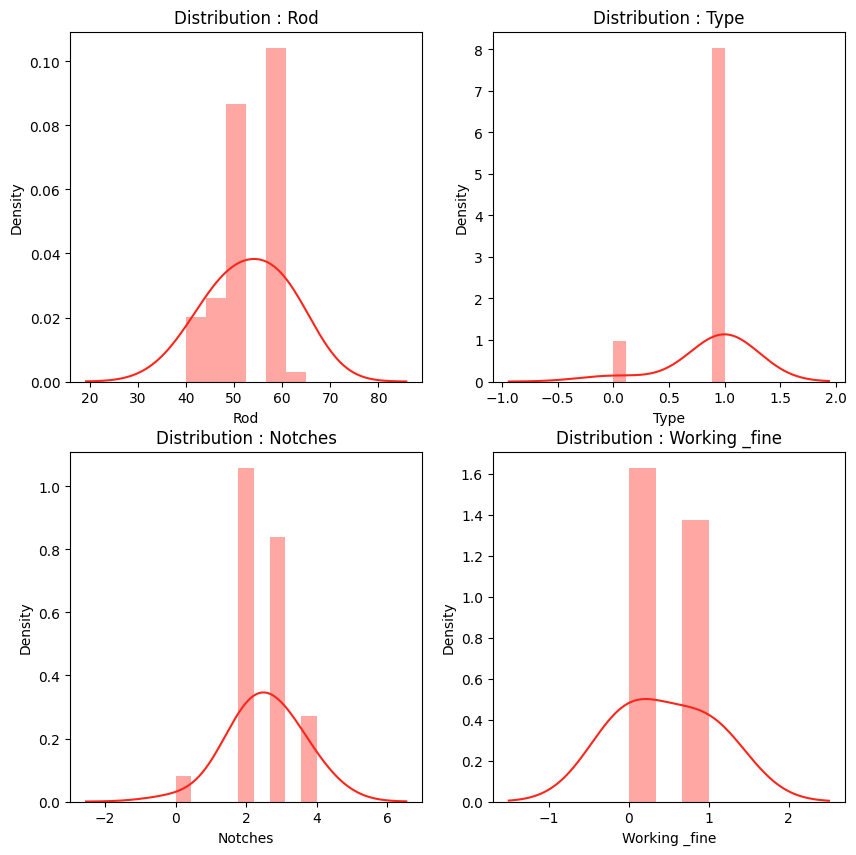

In [356]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (10,10))
for i in range(len(categorical_features)):
    
    plt.subplot(2,2,i+1)
    sns.distplot(df[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

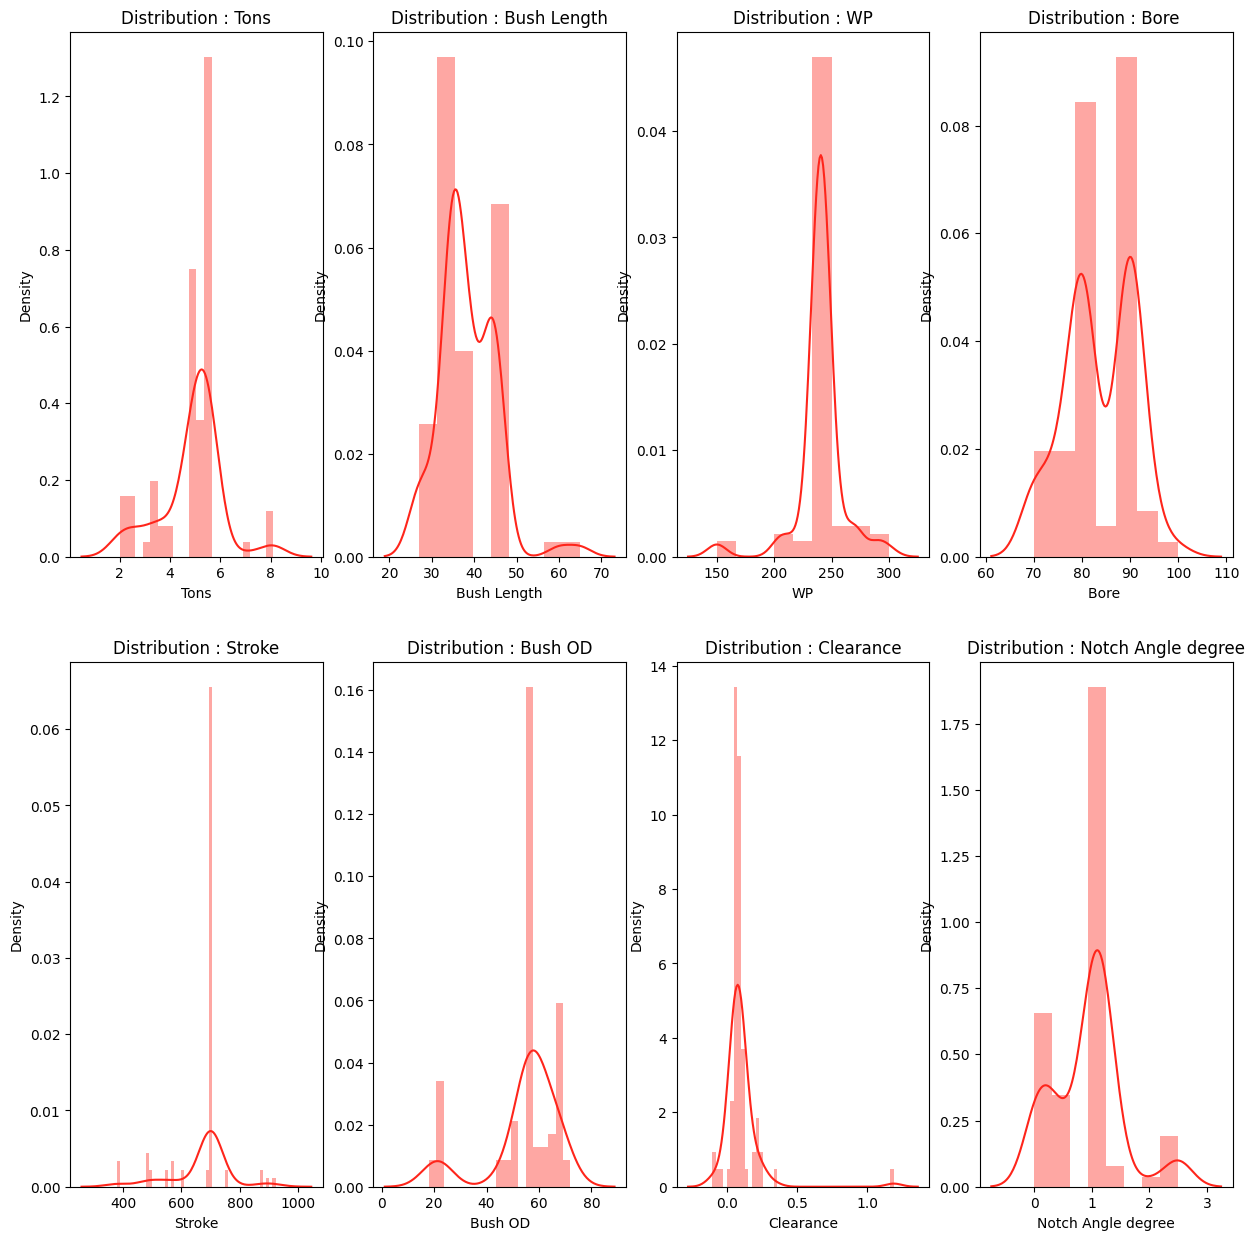

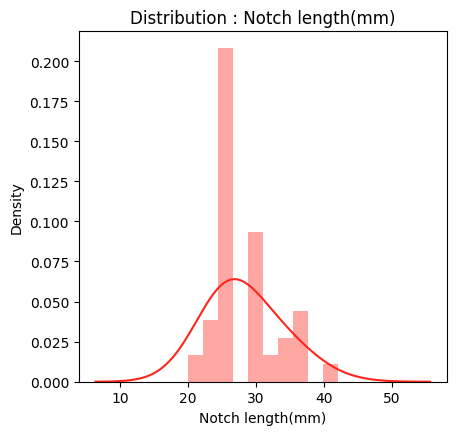

In [361]:
fig, ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,15))
for i in range(len(numerical_features) - 1):
    plt.subplot(2,4,i+1)
    sns.distplot(df[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

plt.figure(figsize = (4.75,4.55))
sns.distplot(df[numerical_features[len(numerical_features) - 1]],kde_kws = {'bw' : 1},color = colors[0])
title = 'Distribution : ' + numerical_features[len(numerical_features) - 1]
plt.title(title);

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Tons'),
  Text(1, 0, 'Bush Length'),
  Text(2, 0, 'WP'),
  Text(3, 0, 'Bore '),
  Text(4, 0, 'Rod'),
  Text(5, 0, 'Stroke'),
  Text(6, 0, 'Type'),
  Text(7, 0, 'Bush OD'),
  Text(8, 0, 'Clearance'),
  Text(9, 0, 'Notches'),
  Text(10, 0, 'Notch Angle degree'),
  Text(11, 0, 'Notch length(mm)')])

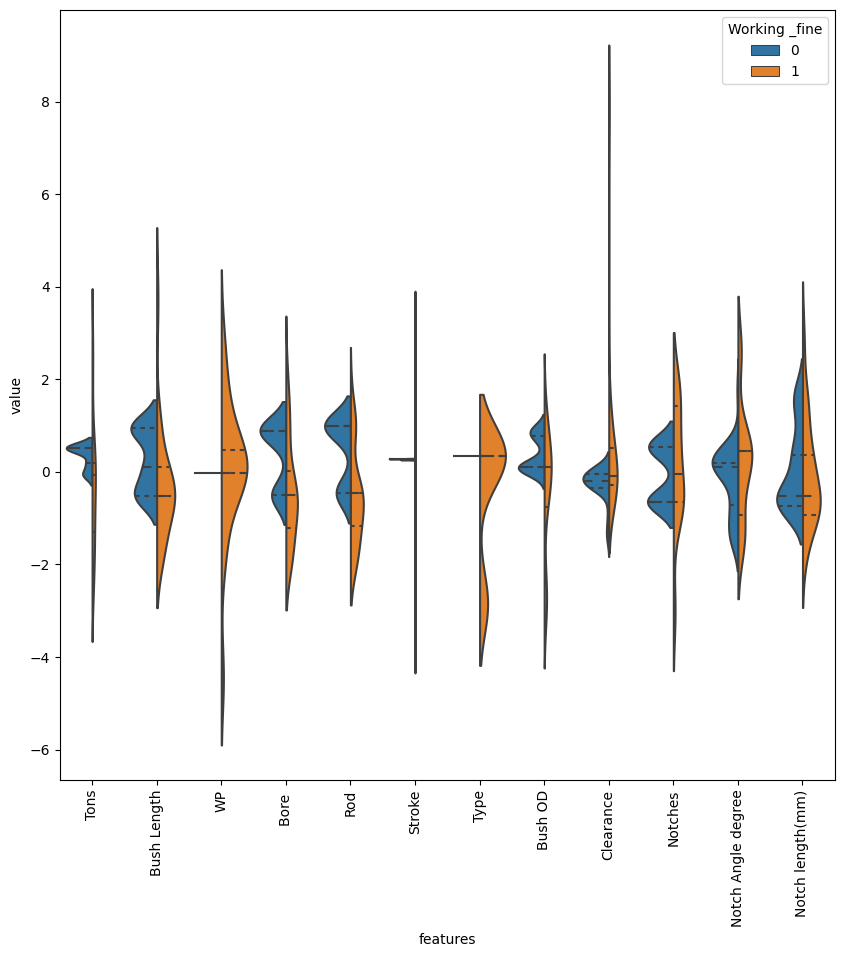

In [23]:
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
data = X
data_n_2 = (data - data.mean()) / (data.std())
data = pd.concat([y,data_n_2],axis=1)
data = pd.melt(data,id_vars="Working _fine",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Working _fine", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

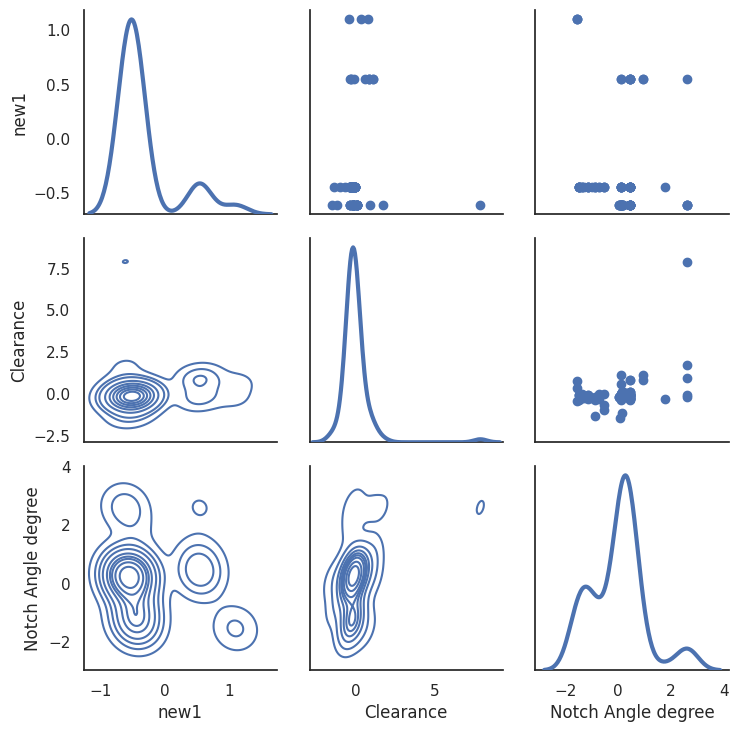

In [382]:
X_copy = data_n_2.copy()
X_copy = (X_copy - X_copy.mean())/X_copy.std() 
# X_copy['new'] = X_copy['Clearance']/X_copy['Notch Angle degree'] 
X_copy['new1'] = np.log(abs(X_copy['Notches']-(X_copy['Notch length(mm)']/1000)**2))  ##besttt

sns.set(style="white")
df = X_copy.loc[:,['new1','Clearance', 'Notch Angle degree' ]]
#Try PCA
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tons                83 non-null     float64
 1   Bush Length         83 non-null     float64
 2   WP                  83 non-null     int64  
 3   Bore                83 non-null     int64  
 4   Rod                 83 non-null     int64  
 5   Stroke              83 non-null     float64
 6   Type                83 non-null     int64  
 7   Bush OD             83 non-null     float64
 8   Clearance           83 non-null     float64
 9   Notches             83 non-null     float64
 10  Notch Angle degree  83 non-null     float64
 11  Notch length(mm)    83 non-null     float64
dtypes: float64(8), int64(4)
memory usage: 7.9 KB


In [8]:
X_copy = X.copy()
cols_to_drop = ['Type', 'Tons' ,'Bush Length'] 
X_copy = X_copy.drop(cols_to_drop , axis= 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
X_copy['diff'] = ((X_copy['Notch length(mm)'])-X_copy['Notches'])**2
X_copy['Clearance_area'] = (np.pi*(2*X_copy['Bush OD']*X_copy['Clearance'] + (X_copy['Clearance'])**2))
X_copy = X_copy.drop(['Notches','Notch length(mm)','Rod','Bush OD'] , axis= 1)


In [2]:
ex = pd.DataFrame(np.array(X_copy.iloc[76]).reshape(1,-1), columns = X_copy.columns)

In [6]:
ex

,WP,Bore,Stroke,Clearance,Notch Angle degree,diff,Clearance_area
0,0.22,-1.21,-0.77,0.83,0.45,1.31,-0.58


In [3]:
y_copy.iloc[76]

1

In [29]:
y_copy = y.copy()
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

accuracy_scores = []
classification_reports = []

for i in range(16):
    X_train, X_test, y_train, y_test = train_test_split(X_copy.iloc[:69], y_copy.iloc[:69], test_size=0.2, random_state=i)
    #Donot change this 69
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    xgb_classifier = XGBClassifier(random_state=4, max_depth=3, learning_rate=0.214, objective='binary:logistic')

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    accuracy_scores.append(accuracy)
    classification_reports.append(report)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

Mean Accuracy: 0.91 ± 0.07


In [30]:
#To_make predictions

X_copy = X.copy()
cols_to_drop = ['Type', 'Tons' ,'Bush Length'] 
X_copy = X_copy.drop(cols_to_drop , axis= 1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
X_copy['diff'] = ((X_copy['Notches']-X_copy['Notch length(mm)']))**2 
X_copy['Clearance_area'] = np.pi*(2*X_copy['Bush OD']*X_copy['Clearance'] + (X_copy['Clearance'])**2)
X_copy = X_copy.drop(['Notches','Notch length(mm)','Rod', 'Bush OD'] , axis= 1)
y_copy = y.copy()
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

accuracy_scores = []
classification_reports = []
predictions = []

for i in range(16):
    X_train, X_test, y_train, y_test = train_test_split(X_copy.iloc[:69], y_copy.iloc[:69], test_size=0.2, random_state=i)
    #Donot change this 69
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    xgb_classifier = XGBClassifier(random_state=4, max_depth=3, learning_rate=0.214, objective='binary:logistic')

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)
    y_new = xgb_classifier.predict(ex)
    predictions.append(y_new[0])
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    accuracy_scores.append(accuracy)
    classification_reports.append(report)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_prediction = np.mean(predictions)

print(f"Predictions for the new example across different random states: {predictions}")
print(f"Mean prediction for the new example: {mean_prediction}")
ans = 1 if mean_prediction > 0.5 else 0
print(f"Bush fine? {ans}")
print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

Predictions for the new example across different random states: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Mean prediction for the new example: 1.0
Bush fine? 1
Mean Accuracy: 0.91 ± 0.07


In [48]:
cols_needed = list(df.columns[:7])
cols_simulate = list(df.columns[7:-1])

In [50]:
cols_needed

['Tons', 'Bush Length', 'WP', 'Bore ', 'Rod', 'Stroke', 'Type']

In [49]:
cols_simulate

['Bush OD', 'Clearance', 'Notches', 'Notch Angle degree', 'Notch length(mm)']

In [35]:
Bush_OD = 22
Bush_OD_l = 0
Bush_OD_h = 0.033

Counter_OD = 22
Counter_OD_l = -0.24
Counter_OD_h = -0.22

Clearance = abs((Counter_OD+Counter_OD_l)-(Bush_OD+Bush_OD_h)+(Counter_OD+Counter_OD_h)-(Bush_OD+Bush_OD_l))/2

In [58]:
Notches = 0
Notch_length = 0
Notch_Angle = 0
Clearance = 0
Bush_OD = 0
diff =( Notches - Notch_length)**2
clearance_area = np.pi*(2*Bush_OD*Clearance + (Clearance)**2)

In [72]:
X_copy.columns

Index(['WP', 'Bore ', 'Stroke', 'Clearance', 'Notch Angle degree', 'diff',
       'Clearance_area'],
      dtype='object')

In [ ]:
example = np.array([WP, Bore, Stroke ,Clearance,Notch_Angle,diff,clearance_area ])

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('/kaggle/input/data-bore/Data_withbore.csv')
df['Working _fine'] = df['Working _fine'].apply(lambda x: 1 if x == 'Y' else 0) 
cols = ['Notches' , 'Notch Angle degree']
df[cols] = df[cols].bfill()

label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df = df.sample(frac = 1.0 , random_state = 42)
df = df.reset_index(drop = True)
df_temp = df.copy()
X = df_temp.drop('Bush OD' , axis = 1)
y = df_temp.pop('Bush OD')
not_null_ind = []
null_ind = []
for i,ele in enumerate(y):
    if pd.isna(ele) == False:
        not_null_ind.append(i)
    else:
        null_ind.append(i)
X_temp = X.iloc[not_null_ind]
y_temp = y.iloc[not_null_ind]

X_temp1 = X.iloc[null_ind]

dim_predictions = []
mse_scores = []
r2_scores = []
all_predictions = []
for i in range(27):
    X_train, X_test, y_train, y_test = train_test_split(X_temp[0:46], y_temp[0:46], test_size=0.2, random_state=i)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    regressor = DecisionTreeRegressor(random_state=4)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_temp1 = regressor.predict(X_temp1)
    all_predictions.append(y_temp1)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
all_predictions = np.array(all_predictions)

y_pred_final = np.mean(all_predictions, axis=0)

print("Predictions for Bush_ODs :", y_pred_final)

print(f"Mean MSE: {mean_mse:.2f} ± {std_mse:.2f}")
print(f"Mean R^2: {mean_r2:.2f} ± {std_r2:.2f}")

df.loc[null_ind , 'Bush OD'] = y_pred_final
df_temp = df.copy()
X = df_temp.drop('Working _fine' , axis = 1)
y = df_temp.pop('Working _fine')

X_copy = X.copy()
cols_to_drop = ['Type', 'Tons' ,'Bush Length'] 
X_copy = X_copy.drop(cols_to_drop , axis= 1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
X_copy['diff'] = ((X_copy['Notches']-X_copy['Notch length(mm)']))**2 
X_copy['Clearance_area'] = np.pi*(2*X_copy['Bush OD']*X_copy['Clearance'] + (X_copy['Clearance'])**2)
X_copy = X_copy.drop(['Notches','Notch length(mm)','Rod', 'Bush OD'] , axis= 1)
y_copy = y.copy()
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
# scaler = StandardScaler()
# X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)

accuracy_scores = []
classification_reports = []
predictions = []

for i in range(16):
    X_train, X_test, y_train, y_test = train_test_split(X_copy.iloc[:69], y_copy.iloc[:69], test_size=0.2, random_state=i)
    #Donot change this 69
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    xgb_classifier = XGBClassifier(random_state=4, max_depth=3, learning_rate=0.214, objective='binary:logistic')

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)
    y_new = xgb_classifier.predict(ex)
    predictions.append(y_new[0])
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    accuracy_scores.append(accuracy)
    classification_reports.append(report)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_prediction = np.mean(predictions)

print(f"Predictions for the new example across different random states: {predictions}")
print(f"Mean prediction for the new example: {mean_prediction}")
ans = 1 if mean_prediction > 0.5 else 0
if(ans == 1):
    dim_predictions.append(ans)
print(f"Bush fine? {ans}")
print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

Predictions for Bush_ODs : [56.96896296 56.97814815 57.00222222 56.95177778 64.71462963 65.45259259
 56.99814815 56.97814815 56.95177778 63.80407407 64.52944444 56.99703704
 64.97185185]
Mean MSE: 22.14 ± 31.97
Mean R^2: 0.85 ± 0.18
Predictions for the new example across different random states: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Mean prediction for the new example: 1.0
Bush fine? 1
Mean Accuracy: 0.91 ± 0.07


In [73]:
user_input = {'Tons': 4.8, 'Bush Length': 35, 'WP': 240, 'Bore ': 80, 'Rod': 50, 'Stroke': 698.5, 'Type': 1}  # Example user input


In [76]:
df.columns

Index(['Tons', 'Bush Length', 'WP', 'Bore ', 'Rod', 'Stroke', 'Type',
       'Bush OD', 'Clearance', 'Notches', 'Notch Angle degree',
       'Notch length(mm)', 'Working _fine'],
      dtype='object')

In [75]:
pd.DataFrame(np.array([user_input['Tons'],user_input['Bush Length'],user_input['WP'],user_input['Bore'],user_input['Rod'],user_input['Stroke'],user_input['Type']]))

4.8

In [102]:
df['Bush OD'].max()

72.0

Take Min and max of bush OD as well as clearance as input,
Reject any negative dimensions, Mention in the interface to put 1 or 0 as type



In [139]:
Bush_od_min = 18
Bush_od_max = 20
df['Clearance'].max()
# clear_max = df['Clearance'].max()
# df['Notch length(mm)'].max()
# df['Notch Angle degree'].max()

1.19

In [129]:

sample = user_input.copy()
sample['Bush OD'] = np.random.uniform(Bush_od_min, Bush_od_max)
sample['Clearance'] = np.random.uniform(clear_min, clear_max)
sample['Notches'] = np.random.randint(0, 5)
sample['Notch Angle degree'] = np.random.uniform(0,2.5)
sample['Notch length(mm)'] = np.random.uniform(5,user_input['Bush Length'] )

sample_df = pd.DataFrame([sample])
sample_df['diff'] = ((sample_df['Notches'] - sample_df['Notch length(mm)']))**2 
sample_df['Clearance_area'] = np.pi * (2 * sample_df['Bush OD'] * sample_df['Clearance'] + (sample_df['Clearance'])**2)
sample_df_test = sample_df.drop(['Notches', 'Notch length(mm)', 'Rod', 'Bush OD'], axis=1)

In [121]:
sample_df

,Tons,Bush Length,WP,Bore,Rod,Stroke,Type,Bush OD,Clearance,Notches,Notch Angle degree,Notch length(mm),diff,Clearance_area
0,4.80,35,240,80,50,698.50,1,18.69,0.15,1,1.78,5.17,17.41,17.26


In [130]:
def make_df(user_input):
    sample = user_input.copy()
    sample['Bush OD'] = np.random.uniform(Bush_od_min, Bush_od_max)
    sample['Clearance'] = np.random.uniform(clear_min, clear_max)
    sample['Notches'] = np.random.randint(0, 5)
    sample['Notch Angle degree'] = np.random.uniform(0,2.5)
    sample['Notch length(mm)'] = np.random.uniform(5,user_input['Bush Length'] )
    sample_df = pd.DataFrame([sample])

    cols_to_drop = ['Type', 'Tons' ,'Bush Length'] 
    X_copy = sample_df.drop(cols_to_drop , axis= 1)

    scaler = StandardScaler()
    X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
    X_copy['diff'] = ((X_copy['Notches']-X_copy['Notch length(mm)']))**2 
    X_copy['Clearance_area'] = np.pi*(2*X_copy['Bush OD']*X_copy['Clearance'] + (X_copy['Clearance'])**2)
    X_copy = X_copy.drop(['Notches','Notch length(mm)','Rod', 'Bush OD'] , axis= 1)
    
#     sample_df['diff'] = ((sample_df['Notches'] - sample_df['Notch length(mm)']))**2 
#     sample_df['Clearance_area'] = np.pi * (2 * sample_df['Bush OD'] * sample_df['Clearance'] + (sample_df['Clearance'])**2)
#     sample_df_test = sample_df.drop(['Notches', 'Notch length(mm)', 'Rod', 'Bush OD'], axis=1)
    
    return sample_df,X_copy

In [134]:
import pickle

with open('X_copy.pkl', 'wb') as f:
    pickle.dump(X_copy, f)

with open('y_copy.pkl', 'wb') as f:
    pickle.dump(y_copy, f)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

def make_predictions(ex):
    accuracy_scores = []
    classification_reports = []
    predictions = []

    for i in range(16):
        X_train, X_test, y_train, y_test = train_test_split(X_copy.iloc[:69], y_copy.iloc[:69], test_size=0.2, random_state=i)
        #Donot change this 69

        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
        xgb_classifier = XGBClassifier(random_state=4, max_depth=3, learning_rate=0.214, objective='binary:logistic')

        xgb_classifier.fit(X_train, y_train)

        y_pred = xgb_classifier.predict(X_test)
        y_new = xgb_classifier.predict(ex)
        predictions.append(y_new[0])
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        accuracy_scores.append(accuracy)
        classification_reports.append(report)

    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)

    mean_prediction = np.mean(predictions)

    print(f"Predictions for the new example across different random states: {predictions}")
    print(f"Mean prediction for the new example: {mean_prediction}")
    ans = 1 if mean_prediction > 0.5 else 0
    if(ans == 1):
        dim_predictions.append(ans)
    print(f"Bush fine? {ans}")
    print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")
    
    return dim_predictions

In [131]:
user_input = {'Tons': 4.8, 'Bush Length': 35, 'WP': 240, 'Bore ': 80, 'Rod': 50, 'Stroke': 698.5, 'Type': 1 }  # Example user input
samples = 100
for _ in range(samples):
    sample_df,sample_df_test = make_df(user_input)
    

In [133]:
sample_df

,Tons,Bush Length,WP,Bore,Rod,Stroke,Type,Bush OD,Clearance,Notches,Notch Angle degree,Notch length(mm)
0,4.80,35,240,80,50,698.50,1,19.76,-0.11,4,0.58,6.71


In [128]:
X_copy

,WP,Bore,Stroke,Clearance,Notch Angle degree,diff,Clearance_area
0,-0.03,0.90,0.29,-1.21,0.15,1.19,4.64
1,-0.03,-0.51,0.27,0.11,0.45,1.13,0.11
2,-0.03,0.90,0.29,0.10,0.45,1.10,0.52
3,-0.03,0.90,0.29,-1.50,0.08,1.19,7.15
4,-0.03,0.90,0.29,-0.12,-1.48,2.83,-0.62
...,...,...,...,...,...,...,...
78,-0.03,0.90,0.29,-0.12,0.45,0.03,-0.62
79,-0.03,-0.51,0.27,-0.08,0.45,0.02,-0.03
80,1.46,-1.21,-1.80,1.12,0.95,7.26,-14.89
81,-0.03,0.90,0.29,0.10,0.45,0.03,0.60


In [119]:
import numpy as np 
import pandas as pd 
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess data
df = pd.read_csv('/kaggle/input/data-bore/Data_withbore.csv')
df['Working _fine'] = df['Working _fine'].apply(lambda x: 1 if x == 'Y' else 0) 
cols = ['Notches' , 'Notch Angle degree']
df[cols] = df[cols].bfill()

label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df = df.sample(frac = 1.0 , random_state = 42)
df = df.reset_index(drop = True)
df_temp = df.copy()
X = df_temp.drop('Bush OD' , axis = 1)
y = df_temp.pop('Bush OD')
not_null_ind = []
null_ind = []
for i,ele in enumerate(y):
    if pd.isna(ele) == False:
        not_null_ind.append(i)
    else:
        null_ind.append(i)
X_temp = X.iloc[not_null_ind]
y_temp = y.iloc[not_null_ind]

X_temp1 = X.iloc[null_ind]

dim_predictions = []
mse_scores = []
r2_scores = []
all_predictions = []
for i in range(27):
    X_train, X_test, y_train, y_test = train_test_split(X_temp[0:46], y_temp[0:46], test_size=0.2, random_state=i)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    regressor = DecisionTreeRegressor(random_state=4)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_temp1 = regressor.predict(X_temp1)
    all_predictions.append(y_temp1)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
all_predictions = np.array(all_predictions)

y_pred_final = np.mean(all_predictions, axis=0)

print("Predictions for Bush_ODs :", y_pred_final)

print(f"Mean MSE: {mean_mse:.2f} ± {std_mse:.2f}")
print(f"Mean R^2: {mean_r2:.2f} ± {std_r2:.2f}")

df.loc[null_ind , 'Bush OD'] = y_pred_final
df_temp = df.copy()
X = df_temp.drop('Working _fine' , axis = 1)
y = df_temp.pop('Working _fine')

X_copy = X.copy()
cols_to_drop = ['Type', 'Tons' ,'Bush Length'] 
X_copy = X_copy.drop(cols_to_drop , axis= 1)

scaler = StandardScaler()
X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
X_copy['diff'] = ((X_copy['Notches']-X_copy['Notch length(mm)']))**2 
X_copy['Clearance_area'] = np.pi*(2*X_copy['Bush OD']*X_copy['Clearance'] + (X_copy['Clearance'])**2)
X_copy = X_copy.drop(['Notches','Notch length(mm)','Rod', 'Bush OD'] , axis= 1)
y_copy = y.copy()

accuracy_scores = []
classification_reports = []
predictions = []

for i in range(16):
    X_train, X_test, y_train, y_test = train_test_split(X_copy.iloc[:69], y_copy.iloc[:69], test_size=0.2, random_state=i)
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    xgb_classifier = XGBClassifier(random_state=4, max_depth=3, learning_rate=0.214, objective='binary:logistic')

    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    accuracy_scores.append(accuracy)
    classification_reports.append(report)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

# Monte Carlo simulation for generating samples and checking the model output
user_input = {'Tons': 4.8, 'Bush Length': 35, 'WP': 240, 'Bore ': 80, 'Rod': 50, 'Stroke': 698.5, 'Type': 1}  # Example user input
samples = 20  # Number of samples to generate

generated_samples = []
for _ in range(samples):
    sample = user_input.copy()
    sample['Bush OD'] = np.random.uniform(df['Bush OD'].min(), df['Bush OD'].max())
    sample['Clearance'] = np.random.uniform(df['Clearance'].min(), df['Clearance'].max())
    sample['Notches'] = np.random.uniform(df['Notches'].min(), df['Notches'].max())
    sample['Notch Angle degree'] = np.random.uniform(df['Notch Angle degree'].min(), df['Notch Angle degree'].max())
    sample['Notch length(mm)'] = np.random.uniform(df['Notch length(mm)'].min(), df['Notch length(mm)'].max())

    sample_df = pd.DataFrame([sample])
    sample_df['diff'] = ((sample_df['Notches'] - sample_df['Notch length(mm)']))**2 
    sample_df['Clearance_area'] = np.pi * (2 * sample_df['Bush OD'] * sample_df['Clearance'] + (sample_df['Clearance'])**2)
    sample_df = sample_df.drop(['Notches', 'Notch length(mm)', 'Rod', 'Bush OD'], axis=1)
    
    sample_df_scaled = scaler.transform(sample_df)
    sample_pred = xgb_classifier.predict(sample_df_scaled)
    
    if sample_pred[0] == 1:
        generated_samples.append(sample)

print(f"Generated samples that returned 'Y': {generated_samples}")


Predictions for Bush_ODs : [56.96896296 56.97814815 57.00222222 56.95177778 64.71462963 65.45259259
 56.99814815 56.97814815 56.95177778 63.80407407 64.52944444 56.99703704
 64.97185185]
Mean MSE: 22.14 ± 31.97
Mean R^2: 0.85 ± 0.18
Mean Accuracy: 0.91 ± 0.07


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Bush Length
- Clearance_area
- Tons
- Type
- diff
Feature names seen at fit time, yet now missing:
- Bush OD
- Notch length(mm)
- Notches
- Rod


In [87]:
X_pred = pd.DataFrame(np.array(X_copy.loc[69:83,:]), columns = X_copy.columns)

In [88]:
X_pred

,WP,Bore,Rod,Stroke,Clearance,Notch Angle degree,log_diff,Clearance_area
0,-0.03,0.90,1.00,0.29,-0.19,0.08,NaN,-0.82
1,-0.03,0.90,1.00,0.29,-0.19,0.03,0.06,-0.01
2,-0.03,-0.51,-0.45,0.27,-0.17,0.45,0.06,-0.02
3,-0.03,-0.51,-0.45,0.27,-0.35,0.11,0.06,0.15
4,-0.03,0.90,1.00,0.29,-0.37,0.45,-1.75,-1.69
5,-0.03,-0.51,-0.45,0.27,-0.02,0.45,NaN,-0.01
6,-0.03,0.90,1.00,0.29,-0.19,0.45,NaN,-0.82
7,0.22,-1.21,-1.18,-0.77,0.83,0.45,0.99,-11.78
8,1.21,1.60,1.00,2.33,0.93,2.62,-1.75,-14.80
9,-0.03,0.90,1.00,0.29,-0.12,0.45,-1.75,-0.63


Feature ranking:
1. feature 5 (0.185150)
2. feature 2 (0.167441)
3. feature 3 (0.165894)
4. feature 0 (0.151806)
5. feature 6 (0.130717)
6. feature 1 (0.107135)
7. feature 4 (0.091857)


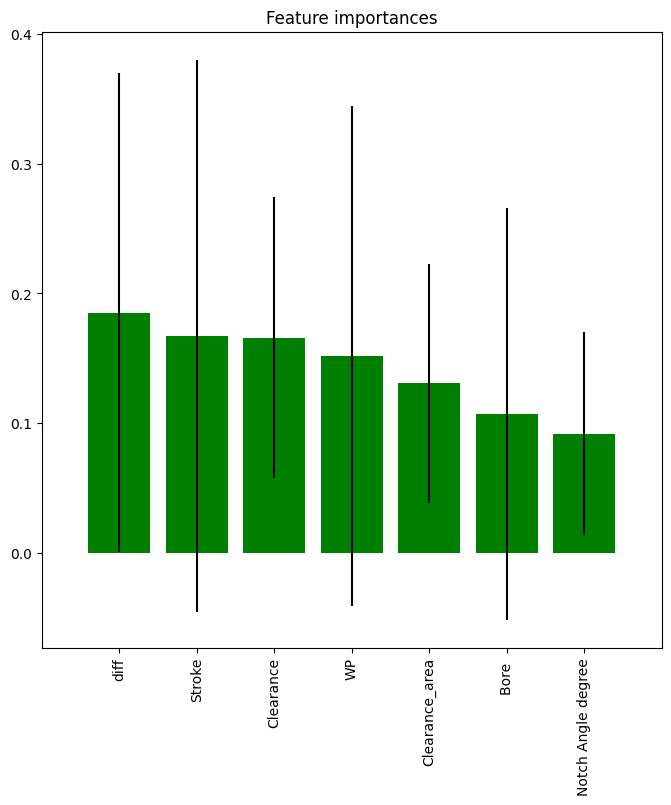

In [75]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [123]:
from sklearn import decomposition
estimator = decomposition.PCA(n_components=6, svd_solver='randomized', whiten=True)
estimator.fit(X_copy)
components_ = estimator.components_

In [125]:
PCA_x = estimator.fit_transform(X_copy)

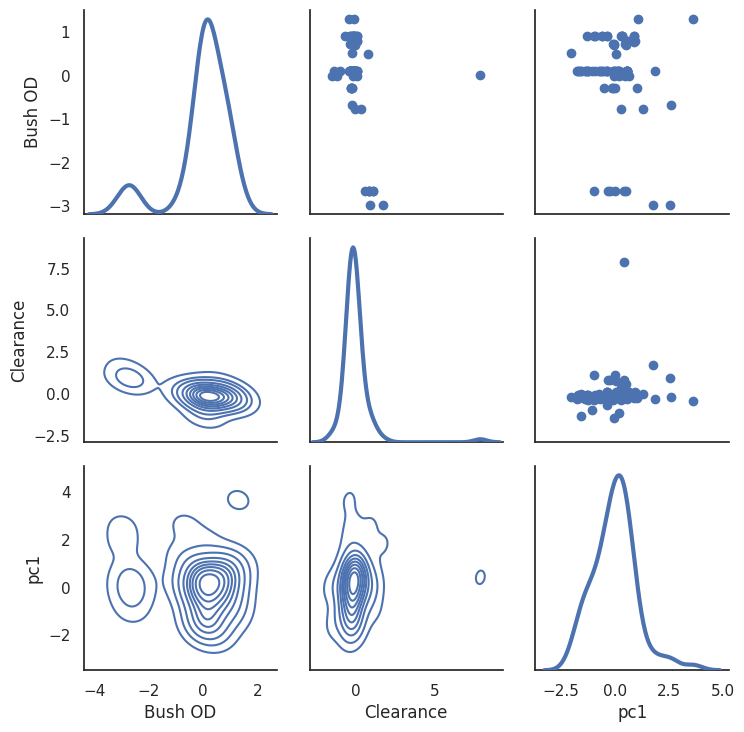

In [141]:
X_copy_temp = data_n_2.copy()
X_copy_temp = (X_copy_temp - X_copy_temp.mean())/X_copy_temp.std() 
# X_copy['new'] = X_copy['Clearance']/X_copy['Notch Angle degree'] 
X_copy_temp['new1'] = np.log(abs(X_copy_temp['Notches']-(X_copy_temp['Notch length(mm)']/1000)**2))  ##besttt
X_copy_temp['pc1'] = pd.DataFrame(PCA_x).loc[:,4]
sns.set(style="white")
df = X_copy_temp.loc[:,['Bush OD','Clearance', 'pc1' ]]
#Try PCA
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [132]:
X1 = pd.DataFrame(PCA_x).loc[:,1]

In [124]:
components_

array([[-7.42378811e-03,  2.20519647e-03, -5.77262938e-04,
         1.75248108e-03,  3.48740911e-02,  9.29079848e-03,
         3.86380696e-03,  9.99309346e-01],
       [ 2.37643177e-01,  5.45747328e-01,  5.42271087e-01,
         5.01705203e-01, -8.89564777e-02,  8.95784245e-02,
        -2.89776663e-01,  3.38653787e-03],
       [-3.66508967e-01, -1.09070305e-02, -5.74260891e-02,
        -1.47212507e-01, -2.07747813e-01, -4.63896576e-01,
        -7.62940894e-01,  1.20391614e-02],
       [-7.47802183e-01,  3.54432802e-01,  3.00861086e-01,
        -9.78694380e-02, -9.00132195e-02, -1.09627606e-01,
         4.41520498e-01, -3.53866538e-03],
       [-3.58742771e-01,  6.69517768e-02, -1.17613953e-01,
        -9.30325913e-02,  2.00691916e-01,  8.22484343e-01,
        -3.56818728e-01, -1.59885768e-02],
       [ 2.36896668e-01,  2.59911167e-01,  3.16608629e-01,
        -6.68563355e-01,  5.53218331e-01, -1.22076114e-01,
        -8.90023757e-02, -1.52855444e-02]])

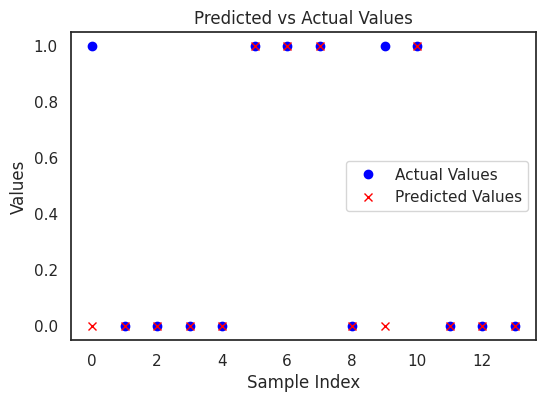

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(y_test, 'o', color='blue', label='Actual Values')
plt.plot(y_pred, 'x', color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

In [252]:
df_test = pd.read_csv('/kaggle/input/data-bore-n/Data_withbore.csv').iloc[43]
df_test_copy = df_test.copy()
#  = df_test_copy['Working _fine'].apply(lambda x: 1 if x == 'Y' else 0)
if df_test_copy['Working _fine'] == 'Y':
    df_test_copy['Working _fine'] = 1
else :
    df_test_copy['Working _fine'] = 0

df_test = df_test.drop(['Type' , 'Working _fine'])


if pd.isna(df_test['Bush OD']) :
    print("hello")
    df_test['Bush OD'] = regressor.predict(np.array(df_test_copy.drop(['Bush OD','Type'])).reshape(1,-1))
print(df_test)
df_test = pd.DataFrame(scaler.transform(np.array(df_test).reshape(1,-1)) , columns = ['Tons' ,'Bush Length','WP','Bore','Rod','Stroke','Bush OD','Clearance','Notches','Notch Angle degree','Notch length(mm)' ])
df_test['new1'] = (df_test['Notches']-df_test['Notch length(mm)']) 
df_test

hello
Tons                   5.50
Bush Length           39.00
WP                      240
Bore                     90
Rod                      60
Stroke               700.50
Bush OD               66.98
Clearance              0.08
Notches                3.00
Notch Angle degree     1.00
Notch length(mm)      30.00
Name: 43, dtype: object


,Tons,Bush Length,WP,Bore,Rod,Stroke,Bush OD,Clearance,Notches,Notch Angle degree,Notch length(mm),new1
0,0.52,0.10,-0.03,0.90,1.00,0.29,0.92,-0.14,0.54,0.11,0.37,0.17


In [385]:
# print(X_copy.iloc[X_copy.shape[0]-1])
# X_copy['new'] = np.log(abs(X_copy['Notch Angle degree']))
# X_copy['new'] = np.log(abs(X_copy['Notches']))
# X_copy = (X_copy - X_copy.mean())/X_copy.std()

# X_copy['new'] = np.log((abs((X_copy['Notches']+X_copy['Notch Angle degree'])/X_copy['Notch Angle degree']))+1)
# X_copy['new1'] = np.log(abs(X_copy['Notches']-(X_copy['Notch length(mm)']/1000)**2/X_copy['Notch Angle degree']))  ##besttt

# X_copy['new'] = np.log(np.sqrt(abs(X_copy['Notch Angle degree']-X_copy['Notches']))+1)

# X_copy['new1'] = np.log(abs((X_copy['Clearance'])*(X_copy['Notch Angle degree'])+1))
X_copy = X.copy()
cols_to_drop = ['Type'] 
X_copy = X_copy.drop(cols_to_drop , axis= 1)
# print(X_copy.iloc[0])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_copy = pd.DataFrame(scaler.fit_transform(X_copy),columns = X_copy.columns)
X_copy['new1'] = np.log(abs(X_copy['Notches']-(X_copy['Notch length(mm)']/1000)**2/X_copy['Notch Angle degree']))  ##besttt
# X_copy['new2'] = np.sqrt((X_copy['Bush OD']))
# X_copy['new'] = X_copy['Clearance']/X_copy['Notch Angle degree'] 

# X_copy['new2'] = np.log(abs(X_copy['Bush OD']/1000)) 
# X_copy['new2'] = X_copy['Rod']*X_copy['WP']

**Monte Carlo Cross-Validation (MCCV)**


In [386]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Your specific example for prediction
# df_test = ...  # Replace with your specific example
X_new = np.array(df_test).reshape(1, -1)
cols_to_drop = ['Type' , 'WP', 'Rod' ,'Bore' ,'Bush Length' , 'Clearance'] 

# Arrays to store the accuracy scores and predictions
accuracy_scores = []
predictions = []

# Loop over random states from 0 to 42
for i in range(43):
    # Split the data with the current random state
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=i)

    # Reset index
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Create an instance of the XGBClassifier
    xgb_classifier = XGBClassifier(random_state=42, max_depth=3, learning_rate=0.15, objective='binary:logistic')

    # Fit the classifier to the training data
    xgb_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Predict on the new example
#     new_pred = xgb_classifier.predict(X_new)

#     # Store the prediction
#     predictions.append(new_pred[0])

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Store the accuracy score
    accuracy_scores.append(accuracy)

# Calculate the mean and standard deviation of the accuracy scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

# Calculate the mean prediction for the new example
mean_prediction = np.mean(predictions)

print(f"Predictions for the new example across different random states: {predictions}")
print(f"Mean prediction for the new example: {mean_prediction}")


Mean Accuracy: 0.81 ± 0.07
Predictions for the new example across different random states: []
Mean prediction for the new example: nan


In [259]:
final_pred = lambda x : 1 if mean_prediction > 0.5 else 0
print(final_pred(mean_prediction))

0


In [339]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tons                66 non-null     float64
 1   Bush Length         66 non-null     float64
 2   WP                  66 non-null     float64
 3   Bore                66 non-null     float64
 4   Rod                 66 non-null     float64
 5   Stroke              66 non-null     float64
 6   Bush OD             66 non-null     float64
 7   Clearance           66 non-null     float64
 8   Notches             66 non-null     float64
 9   Notch Angle degree  66 non-null     float64
 10  Notch length(mm)    66 non-null     float64
 11  new1                66 non-null     float64
 12  new2                66 non-null     float64
dtypes: float64(13)
memory usage: 6.8 KB


Feature ranking:
1. feature 6 (0.157034)
2. feature 11 (0.132693)
3. feature 0 (0.113258)
4. feature 12 (0.104266)
5. feature 7 (0.101616)
6. feature 2 (0.085858)
7. feature 5 (0.072161)
8. feature 10 (0.060665)
9. feature 4 (0.049190)
10. feature 9 (0.044459)
11. feature 1 (0.031168)
12. feature 3 (0.026512)
13. feature 8 (0.021119)


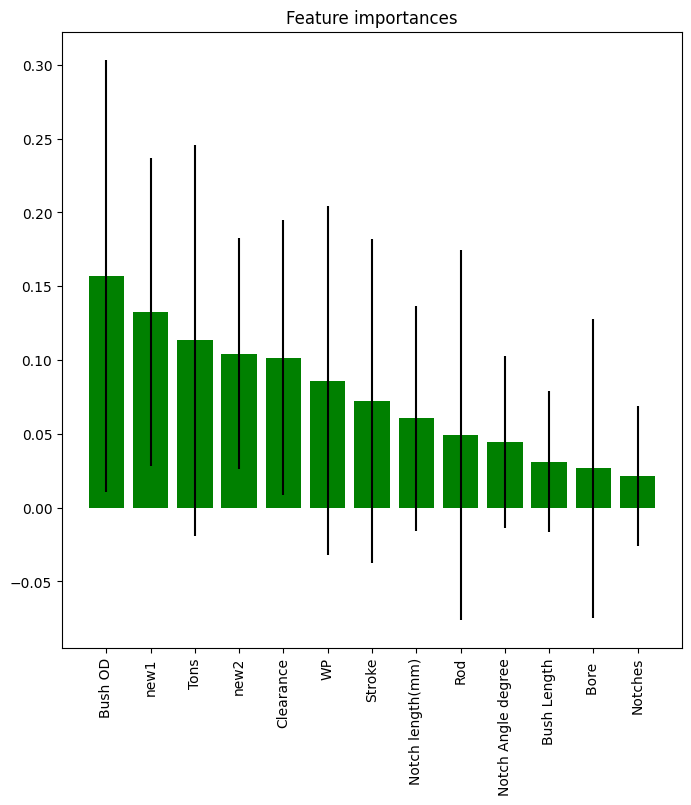

In [341]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [172]:
X_ex = pd.DataFrame(pd.Series(X_copy.iloc[X_copy.shape[0]-1]), columns = X_copy.columns)

In [202]:
X_ex

,Tons,Bush Length,WP,Bore,Rod,Stroke,Bush OD,Clearance,Notch Angle degree,Notch length(mm),new1


In [232]:
X_example = np.array(X_example).reshape(1,-1)

X_example

array([[-1.89371152, -1.70062526,  1.42719725, -1.84786664, -1.15740425,
        -1.87458832, -2.55032816,  1.07179782,  0.93317765, -0.94332185,
         2.62771035]])

In [208]:
y_pred

array([1])

In [81]:
X_example = pd.Series(X_train.loc[0].copy())

In [82]:
len(X_example.index)

11

In [58]:
X_example['Tons'] = 2.5
X_example['Bush Length'] = 27
X_example['Bush OD'] = 22
X_example['Clearance'] = 0.2465
X_example['Notch length(mm)'] = 24

In [114]:
X_example['new'] = abs(X_example['Notches']-X_example['Notch length(mm)'])

In [117]:
X_train.iloc[0]

Tons                 -1.865773
Bush Length          -0.514005
WP                    1.453832
Bore                 -1.201440
Rod                  -1.173898
Stroke               -1.785077
Bush OD              -0.297910
Clearance            -0.297635
Notch Angle degree    0.445031
Notch length(mm)      1.472358
new                   0.544919
Name: 0, dtype: float64

In [116]:
y_pred = xgb_classifier.predict(X_example)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:83: object

Feature ranking:
1. feature 6 (0.171491)
2. feature 7 (0.133884)
3. feature 0 (0.123581)
4. feature 10 (0.117276)
5. feature 5 (0.108209)
6. feature 8 (0.076355)
7. feature 4 (0.065904)
8. feature 3 (0.063445)
9. feature 2 (0.052329)
10. feature 1 (0.045772)
11. feature 9 (0.041753)


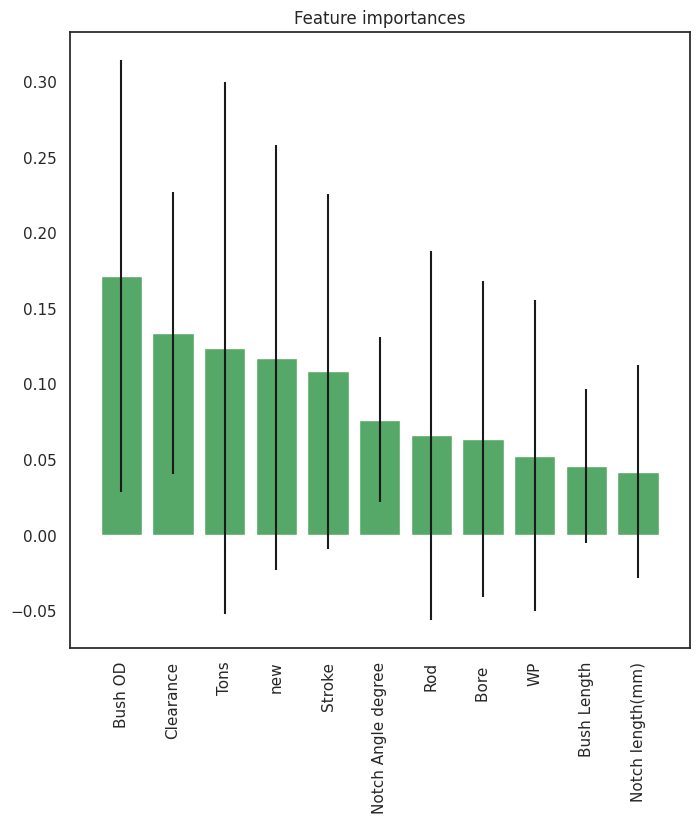

In [37]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

<Axes: >

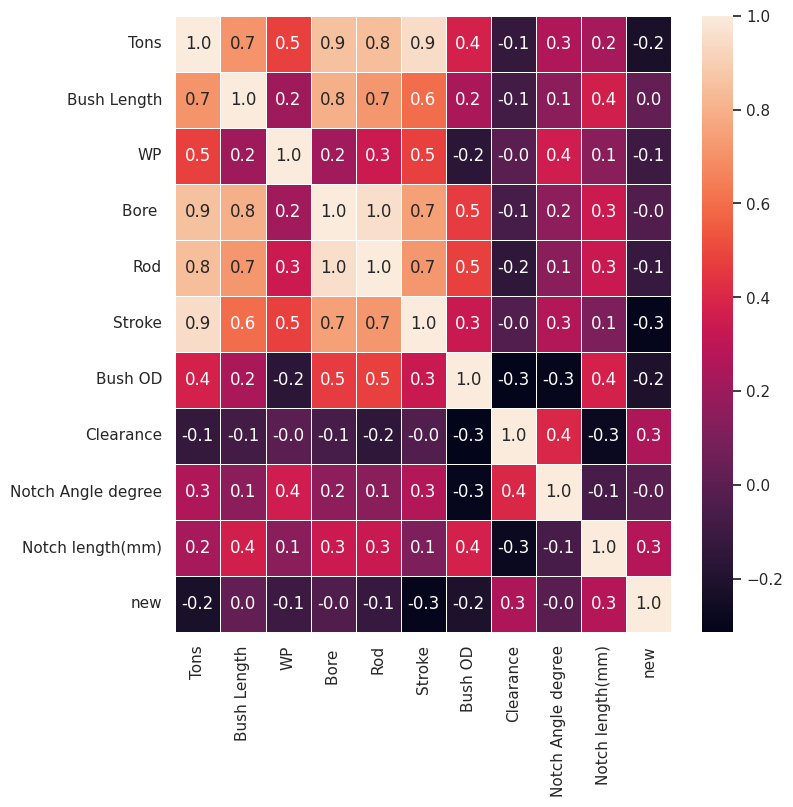

In [39]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_copy.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)